In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm, exponnorm, skewnorm, lognorm, kstest, weibull_min

In [16]:
#Load responses
url = 'https://raw.githubusercontent.com/DavidAgost-Beltran/rotation_perception_experiment/refs/heads/main/responses.csv'
df = pd.read_csv(url,header=0, on_bad_lines='skip')


  gender age_group transformation  image_id_01  distortion_level_11  \
0    man     41-50       rotation            1                  2.0   
1    man     41-50       rotation            1                  3.0   
2    man     41-50       rotation            1                  4.0   
3    man     41-50       rotation            1                  6.0   
4    man     41-50       rotation            2                  3.0   

   distortion_level_12  distortion_level_21  distortion_level_22  \
0                  1.0                  4.0                  6.0   
1                  2.0                 10.0                  4.0   
2                  3.0                  6.0                  8.0   
3                  3.0                  1.0                  2.0   
4                  5.0                  9.0                  8.0   

   reaction_time_ms  answer  
0            3335.0       2  
1            3936.0       2  
2            5875.0       2  
3            3143.0       1  
4            7

In [17]:
# Remove trials with excessively long reaction times and keep only 'rotation' transformations

df=df[df['reaction_time_ms']<30000]
df=df[(df['transformation'] == 'rotation')]


In [18]:
# Compute distortion differences within each pair and between pairs, scaled to degrees (1 unit = 2°)
df['diff_pair1'] = abs(df['distortion_level_11'] - df['distortion_level_12'])
df['diff_pair2'] = abs(df['distortion_level_21'] - df['distortion_level_22'])
df['diff_no_abs'] = (df['diff_pair1'] - df['diff_pair2']) * 2
df['diff_abs'] = abs(df['diff_pair1'] - df['diff_pair2']) * 2


## Psychometric curve

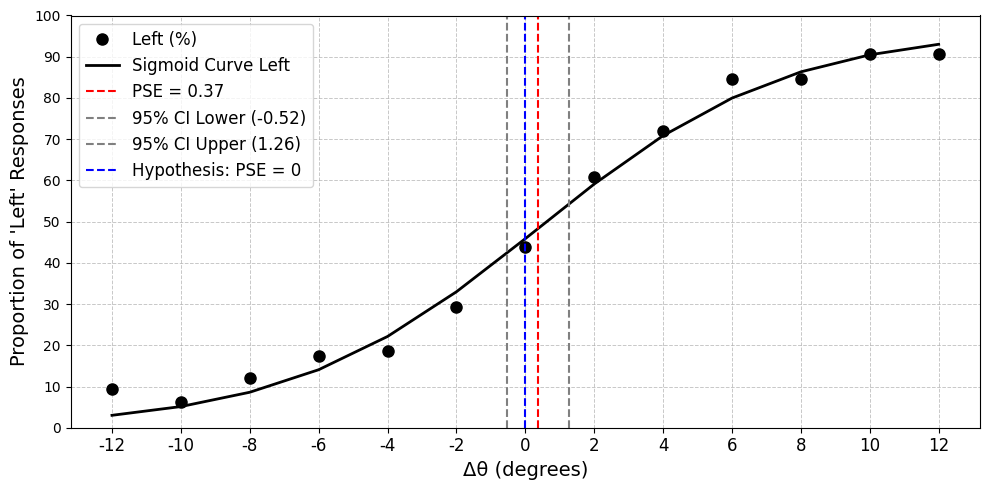

In [19]:
# Select trials where the participant responded 'left' (coded as 1)
df_left = df[df['answer'] == 1]

# Extract sorted unique distortion differences for analysis
rotation_differences = np.sort(df['diff_no_abs'].unique())

# Calculate percentage of 'left' responses for each distortion difference
left_percentages = []
for diff in rotation_differences:
    left_count = len(df_left[df_left['diff_no_abs'] == diff])
    total_count = len(df[df['diff_no_abs'] == diff])
    left_percentages.append((left_count / total_count) * 100)

# Define sigmoid function for psychometric curve fitting
def sigmoid(x, P0, k, x0):
    return P0 / (1 + np.exp(-k * (x - x0)))

# Fit sigmoid to observed data, initializing parameters [max response, slope, PSE]
params_left, covariance_left = curve_fit(sigmoid, rotation_differences, left_percentages, p0=[100, 1, 0])

# Generate fitted sigmoid values for plotting
left_fit = sigmoid(rotation_differences, *params_left)

# Calculate standard errors from covariance matrix
perr_left = np.sqrt(np.diag(covariance_left))

# Compute 95% confidence interval for PSE (point of subjective equality)
ci_x0_lower = params_left[2] - 1.96 * perr_left[2]
ci_x0_upper = params_left[2] + 1.96 * perr_left[2]

# Initialize the figure with specified size
plt.figure(figsize=(10, 5))

# Plot observed percentages of 'left' responses
plt.plot(rotation_differences, left_percentages, 'o', color='black', label='Left (%)', markersize=8)

# Plot fitted sigmoid curve
plt.plot(rotation_differences, left_fit, '-', color='black', linewidth=2, label='Sigmoid Curve Left')

# Visualize PSE and its confidence interval with vertical lines
plt.axvline(x=params_left[2], color='red', linestyle='--', label=f'PSE = {params_left[2]:.2f}')
plt.axvline(x=ci_x0_lower, color='gray', linestyle='--', label=f'95% CI Lower ({ci_x0_lower:.2f})')
plt.axvline(x=ci_x0_upper, color='gray', linestyle='--', label=f'95% CI Upper ({ci_x0_upper:.2f})')

# Reference line for the null hypothesis of PSE = 0
plt.axvline(x=0, color='blue', linestyle='--', label='Hypothesis: PSE = 0')

# Set axis labels, limits, ticks, and grid style for clarity
plt.xlabel('Δθ (degrees)', fontsize=14)
plt.ylabel("Proportion of 'Left' Responses", fontsize=14)
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))
plt.xticks(rotation_differences, [int(x) for x in rotation_differences], fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.legend(loc='upper left', fontsize=12)

# Display the plot
plt.show()


## Reaction time vs task difficulty

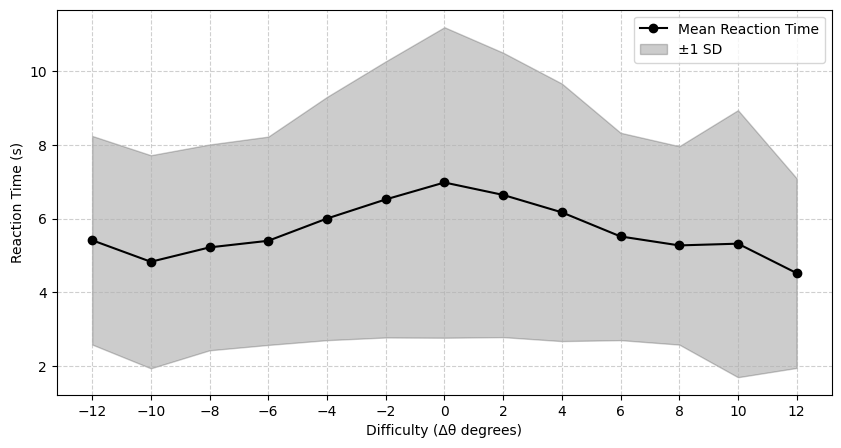

In [20]:
# Group data by absolute difference and calculate mean and standard deviation of reaction times (in seconds)
grouped = df.groupby('diff_no_abs')['reaction_time_ms']
means = grouped.mean() / 1000
std_devs = grouped.std() / 1000

# Extract difficulty levels (x-axis) and corresponding mean reaction times and standard deviations
x_values = means.index
y_values = means
error = std_devs

# Initialize the figure with specified size
plt.figure(figsize=(10, 5))

# Plot mean reaction times with connected markers
plt.plot(x_values, y_values, 'o-', color='black', label='Mean Reaction Time')

# Add shaded area representing ±1 standard deviation around the mean
plt.fill_between(
    x_values,
    y_values - error,
    y_values + error,
    color='black',
    alpha=0.2,
    label='±1 SD'
)

# Set axis labels, legend, and grid for clarity
plt.xlabel('Difficulty (Δθ degrees)')
plt.ylabel('Reaction Time (s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure all difficulty values appear on the x-axis ticks
plt.xticks(x_values)
# Display the plot
plt.show()


## Reaction time distribution

Kolmogorov-Smirnov Test Results
         Distribution  KS Statistic        p-value
1         Ex-Gaussian      0.010058   2.594640e-01
4  Shifted Log-Normal      0.015589   1.497396e-02
3          Log-Normal      0.019459   9.776152e-04
5             Weibull      0.070607   5.231898e-44
2         Skew Normal      0.104784   1.590784e-96
0              Normal      0.137579  2.247220e-166


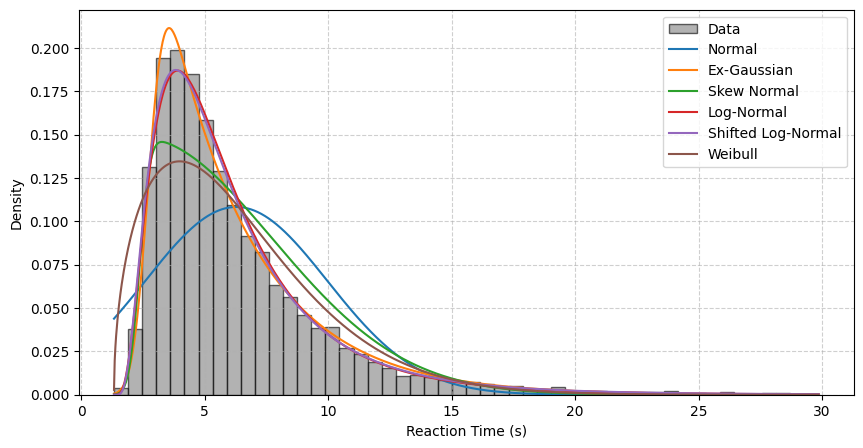

In [21]:
# Extract reaction times in seconds, excluding missing values
reaction_times = df['reaction_time_ms'].dropna().values / 1000

# Keep only positive values, required for log-based distributions
reaction_times = reaction_times[reaction_times > 0]

# Fit Normal distribution and perform Kolmogorov-Smirnov test
mu_norm, std_norm = norm.fit(reaction_times)
k_norm = kstest(reaction_times, 'norm', args=(mu_norm, std_norm))

# Fit Ex-Gaussian distribution and KS test
k_exgaussian, loc_exgaussian, scale_exgaussian = exponnorm.fit(reaction_times)
k_ex = kstest(reaction_times, 'exponnorm', args=(k_exgaussian, loc_exgaussian, scale_exgaussian))

# Fit Skew Normal distribution and KS test
shape_skew, loc_skew, scale_skew = skewnorm.fit(reaction_times)
k_skew = kstest(reaction_times, 'skewnorm', args=(shape_skew, loc_skew, scale_skew))

# Fit Log-Normal distribution and KS test
shape_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(reaction_times)
k_lognorm = kstest(reaction_times, 'lognorm', args=(shape_lognorm, loc_lognorm, scale_lognorm))

# Fit Shifted Log-Normal (manual shift) and KS test
shift = reaction_times.min() - 1e-5  # Small offset to ensure positivity
shifted_data = reaction_times - shift
shape_shifted, loc_shifted, scale_shifted = lognorm.fit(shifted_data, floc=0)
k_shifted_lognorm = kstest(shifted_data, 'lognorm', args=(shape_shifted, loc_shifted, scale_shifted))

# Fit Weibull distribution and KS test
shape_weibull, loc_weibull, scale_weibull = weibull_min.fit(reaction_times)
k_weibull = kstest(reaction_times, 'weibull_min', args=(shape_weibull, loc_weibull, scale_weibull))

# Compile KS statistics and p-values into a summary table
results = pd.DataFrame({
    'Distribution': ['Normal', 'Ex-Gaussian', 'Skew Normal', 'Log-Normal', 'Shifted Log-Normal', 'Weibull'],
    'KS Statistic': [k_norm.statistic, k_ex.statistic, k_skew.statistic, k_lognorm.statistic, k_shifted_lognorm.statistic, k_weibull.statistic],
    'p-value': [k_norm.pvalue, k_ex.pvalue, k_skew.pvalue, k_lognorm.pvalue, k_shifted_lognorm.pvalue, k_weibull.pvalue]
})

print("Kolmogorov-Smirnov Test Results")
print(results.sort_values(by='KS Statistic'))

# Generate x-values for plotting fitted PDFs
x = np.linspace(min(reaction_times), max(reaction_times), 1000)

# Plot histogram of data and fitted probability density functions
plt.figure(figsize=(10, 5))
plt.hist(reaction_times, bins=50, density=True, alpha=0.6, color='gray', edgecolor='black', label='Data')

plt.plot(x, norm.pdf(x, mu_norm, std_norm), label='Normal')
plt.plot(x, exponnorm.pdf(x, k_exgaussian, loc_exgaussian, scale_exgaussian), label='Ex-Gaussian')
plt.plot(x, skewnorm.pdf(x, shape_skew, loc_skew, scale_skew), label='Skew Normal')
plt.plot(x, lognorm.pdf(x, shape_lognorm, loc_lognorm, scale_lognorm), label='Log-Normal')
plt.plot(x, lognorm.pdf(x - shift, shape_shifted, loc_shifted, scale_shifted), label='Shifted Log-Normal')
plt.plot(x, weibull_min.pdf(x, shape_weibull, loc_weibull, scale_weibull), label='Weibull')

plt.xlabel('Reaction Time (s)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# Display the plot
plt.show()
